# Grad CAM exploration

We are modifying the lesson 1 notebook to see if we can implement [Grad-CAM](https://arxiv.org/abs/1610.02391). The idea is to obtain a heatmap of the important areas of the images for the classifier.

The objective is to eventually use this for the satellite project.

In [1]:
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import re
import scipy.ndimage
%matplotlib inline

In [3]:
import fastai
fastai.__version__

'1.0.22'

## Setup
We start by doing the same as in lesson 1 to setup our model.

In [4]:
torch.cuda.set_device(1)

In [5]:
path = Path('/home/henripal/projects/maps/scraper/')
path_img = path/'img'

In [6]:
data = ImageDataBunch.from_csv(path_img, ds_tfms=get_transforms(), size=224, bs=64)
data.normalize(imagenet_stats)

In [7]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.load('resnet50-big-finetuned-bs64')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f6ab0ea9b70>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

## Grad Cam Setup

See [this paper](https://arxiv.org/abs/1610.02391) for details. The idea is to take the outputs of the last "convolutional layer", here a stack of 7x7 feature maps, then weigh them by their importance to the given class using an average of the gradients of those layers wrt the class score vector.

We therefore need to set up two hooks:
- for the feature maps
- for the gradient

Then we linearly combine the feature maps using a reduced version of the gradient to obtain the heatmap.

In [8]:
# we are going to use the output of the last Bottleneck as feature maps
# this is hardcoded for resnet50
target_layer = learn.model[0][-1][-1]
target_layer

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

In [9]:
# hook for the feature maps
fmap_hook = fastai.callbacks.hook_output(target_layer)

In [10]:
# hook for the gradients 
def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

gradient_hook = fastai.callbacks.Hook(target_layer, gradient_torch_hook, is_forward=False)

## Grad Cam

Our hooks are setup, let's run the forward and backward passes to get what we need.

In [11]:
# we start by extracting a batch then choosing one image and label from that batch
# i is the index of the chosen image
i = 50
learn.model.eval()
image_batch, label_batch = next(iter(learn.data.train_dl))
image = image_batch[i].reshape(1, 3, 224, 224)
label = label_batch[i].reshape(-1)

In [12]:
# running the forward pass
out = learn.model(image)

# we need to set the gradients at the output to ones at the predicted class
# and zero everywere else
onehot = torch.zeros(learn.data.c)
onehot[torch.argmax(out)] = 1.0

# we then backprop from there
out.backward(gradient=onehot.reshape(1, -1).cuda())

We've now run our forward and backward passes, we only need to combine the gradients and feature maps to obtain our heat map

In [13]:
gradients = next(iter(gradient_hook.stored))
gradients.shape

torch.Size([1, 2048, 7, 7])

In [14]:
gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1)
fmaps = fmap_hook.stored.cpu().numpy()
print(fmaps.shape)
fmaps = fmaps.reshape(2048, 7, 7)

(1, 2048, 7, 7)


In [15]:
# relu on the heatmap
heatmap = np.maximum(0, np.einsum('i, ijk',gradient_linearization, fmaps))

# we now upsample the heatmap so we can overlay it on our original image
upsampled = scipy.ndimage.zoom(heatmap, 32)
upsampled = (upsampled - np.min(upsampled))/(np.max(upsampled) - np.min(upsampled))

In [16]:
def image_from_tensor(imagetensor):
    numpied = torch.squeeze(imagetensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied

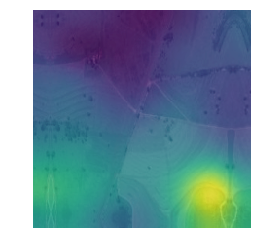

In [17]:
plt.imshow(image_from_tensor(image))
plt.imshow(upsampled, alpha=.8)
plt.gca().set_axis_off()

## Guided Backprop

In [18]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.load('resnet50-big-finetuned-bs64')
learn.model.eval()
image.requires_grad_()
out = learn.model(image)
out.backward(gradient=onehot.reshape(1, -1).cuda())

In [19]:
grad_img = image_from_tensor(image.grad)

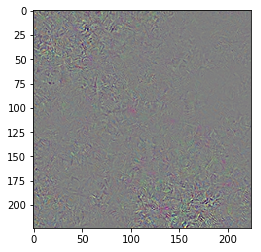

In [20]:
plt.imshow(grad_img)

In [21]:
def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)


In [22]:
relu_modules = [module[1] for module in learn.model.named_modules() if str(module[1]) == "ReLU(inplace)"]
len(relu_modules)

18

In [23]:
hooks = fastai.callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False)

In [24]:
image.requires_grad_()
learn.model.eval()
out = learn.model(image)
out.backward(gradient=onehot.reshape(1, -1).cuda())
grad_img_guided = image_from_tensor(image.grad)

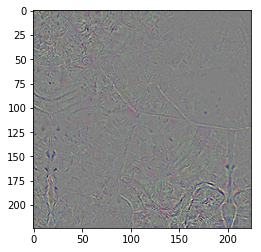

In [25]:
plt.imshow(grad_img_guided)

In [26]:
gbp =  image_from_tensor(image.grad)

In [27]:
prod = np.einsum('ijk, ij->ijk',gbp, upsampled)

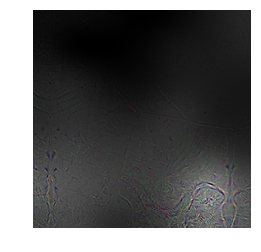

In [28]:
plt.imshow(prod)
plt.gca().set_axis_off()